In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Thesis/Comparison study/Utils')
import data_utils as data
import metric_utils as mtric
import utils

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import pickle
import seaborn as sn
import matplotlib.pyplot as plt


from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from keras.layers import Concatenate

import nltk
nltk.download('stopwords')

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import unicodedata
import re
import gc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# gpu = tf.config.experimental.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#%time data_x, data_y = load_data('dataset/Raw/Train.tsv', [1, 3, 4], True, 1)
MAX_NB_WORDS = 300000
EMBEDDING_DIM = 200
MAX_SEQUENCE_LENGTH = 250

path_train = '/content/gdrive/MyDrive/Thesis/Comparison study/dataset/Processed/Train_coma_blind_num.pickle'
path_test = '/content/gdrive/MyDrive/Thesis/Comparison study/dataset/Processed/Test_coma_blind_num.pickle'
path_w2v = '/content/gdrive/MyDrive/Thesis/Comparison study/w2v/wikipedia-pubmed-and-PMC-w2v (1).bin' # http://evexdb.org/pmresources/vec-space-models/
# path_w2v = 'w2v/Set9_TweetDataWithSpam_GeneralData_Word.bin'

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
dataset = data.Dataset()

dataset.load_pickle(path_train, path_test, label_name='rating')
model = KeyedVectors.load_word2vec_format(path_w2v, binary=True)
#MAX_SEQUENCE_LENGTH = dataset.text_len_distribution(col_name='review', plot=False)[0]

In [ ]:
# Load data from the training file
with open(path_train, 'rb') as train_file:
    train_data = pickle.load(train_file)

# Load data from the test file
with open(path_test, 'rb') as test_file:
    test_data = pickle.load(test_file)

# Display the data from the training file
print("Training data:")
print(train_data.head())

# Display the data from the test file
print("Test data:")
print(test_data.head())

Training data:
                                              review  rating
0  [it, has, no, side, effect, ,, i, take, it, in...     9.0
1  [my, son, is, halfway, through, his, fourth, w...     8.0
2  [i, used, to, take, another, oral, contracepti...     5.0
3  [this, is, my, first, time, using, any, form, ...     8.0
4  [suboxone, has, completely, turned, my, life, ...     9.0
Test data:
                                              review  rating
0  [i, ve, tried, a, few, antidepressants, over, ...    10.0
1  [my, son, has, crohn, s, disease, and, has, do...     8.0
2                   [quick, reduction, of, symptoms]     9.0
3  [contrave, combines, drugs, that, were, used, ...     9.0
4  [i, have, been, on, this, birth, control, for,...     9.0


In [ ]:
# Assuming train_data and test_data are loaded from the pickle files

# Print the column/feature names of the training data
print("Training data features:")
print(train_data.columns.tolist())

# Print the column/feature names of the test data
print("\nTest data features:")
print(test_data.columns.tolist())

Training data features:
['review', 'rating']

Test data features:
['review', 'rating']


In [ ]:
# Assuming train_data is loaded from the pickle file

# Retrieve an element from the loaded pickle file by index
element_index = 0  # Replace with the desired index
element = train_data.iloc[element_index]
print("Element at index", element_index, "in train_data:")
print(element)

Element at index 0 in train_data:
review    [it, has, no, side, effect, ,, i, take, it, in...
rating                                                  9.0
Name: 0, dtype: object


In [ ]:
num_words = len(model.key_to_index)
print(num_words)

5443656


In [ ]:
# dataset.replace(parse_col_name='review', old='#', new='$number')

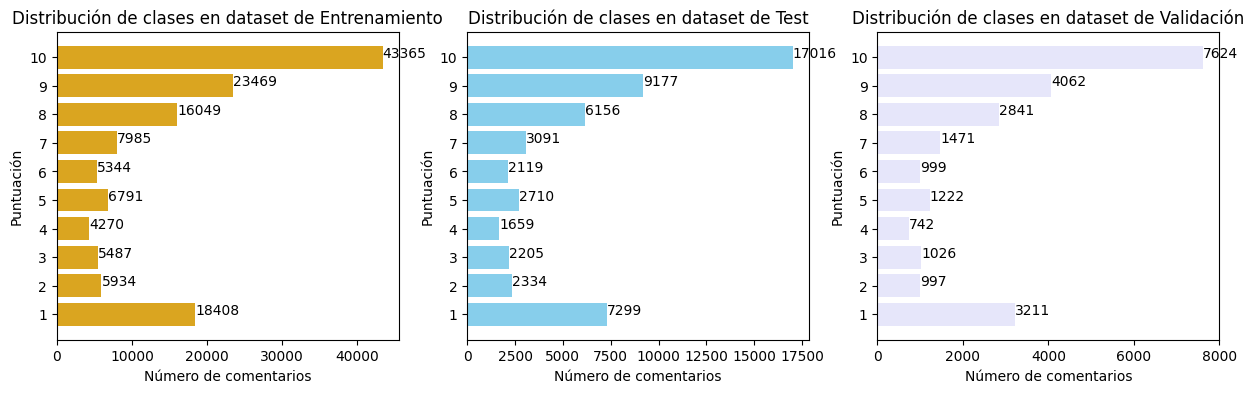

In [ ]:
tokenizer.fit_on_texts([x for x in list(dataset.get_train_x().review)+list(dataset.get_test_x().review)])
dataset.make_dev_split(dev_split=0.15)
dataset.classes_distribution()

In [ ]:
sequences_train = tokenizer.texts_to_sequences(dataset.get_train_x().review)
sequences_dev = tokenizer.texts_to_sequences(dataset.get_dev_x().review)
sequences_test = tokenizer.texts_to_sequences(dataset.get_test_x().review)

Xtrain = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xdev = pad_sequences(sequences_dev, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xtest = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
ytrain = to_categorical(dataset.get_train_y()-dataset.get_train_y().min())
ydev = to_categorical(dataset.get_dev_y()-dataset.get_dev_y().min())
ytest = to_categorical(dataset.get_test_y()-dataset.get_test_y().min())

del sequences_dev, sequences_train, sequences_test
gc.collect()

13275

In [ ]:
word_index = tokenizer.word_index
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM), dtype=np.float32)
count = 0
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in model:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model[word]
        count = count+1
print (count," ",num_words)
#38600   49339

34502   49339


In [ ]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(df_train.label)), np.asarray(df_train.label))
# class_weight_dict = dict(enumerate(class_W))

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = 0
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).argmax(axis=1)
        targ = self.validation_data[1].argmax(axis=1)
        #f1 = f1_score(targ, predict, average='micro')
        mtrcs = precision_recall_fscore_support(targ, predict, average='macro')
        print ("\nPrecision: "+str(mtrcs[0])+"\tRecall: "+str(mtrcs[1])+"\tF1: "+str(mtrcs[2]))
        if (self.f1s < mtrcs[2]):
            self.f1s = mtrcs[2]
            #self.model.save('./model/CNN_static_twitterGeneral_Best_EMRS_model_f1_.hdf5')
            #print("Modelo guardado\n")
        return

metrics = Metrics()

In [ ]:
# class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(dataset.get_train_y())), np.asarray(dataset.get_train_y()))
# class_weight_dict = dict(enumerate(class_W))

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)
conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(drop_out_1)
gmp_2 = GlobalMaxPooling1D(name='gmp_2')(conv_2)
conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(drop_out_1)
gmp_3 = GlobalMaxPooling1D(name='gmp_3')(conv_3)

concat = Concatenate()([gmp_1,gmp_2,gmp_3])
drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
mp_dense = Dense(128, activation='relu', name='mp_dense')(drop_out_2)
preds = Dense(10, activation='softmax', name='preds')(mp_dense)
Conv_model = Model(sequence_input, preds)

Conv_model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

callbacks_list = [metrics]

In [ ]:
Conv_model.fit(Xtrain, ytrain,
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=200,
      epochs=200,
      validation_data=(Xdev, ydev))

Epoch 1/200
686/686 [==============================] - 15s 6ms/step - loss: 1.8721 - accuracy: 0.3539 - val_loss: 1.7107 - val_accuracy: 0.4030
Epoch 2/200
686/686 [==============================] - 4s 5ms/step - loss: 1.6900 - accuracy: 0.4037 - val_loss: 1.6123 - val_accuracy: 0.4272
Epoch 3/200
686/686 [==============================] - 4s 5ms/step - loss: 1.6374 - accuracy: 0.4182 - val_loss: 1.5818 - val_accuracy: 0.4331
Epoch 4/200
686/686 [==============================] - 4s 5ms/step - loss: 1.6100 - accuracy: 0.4251 - val_loss: 1.5607 - val_accuracy: 0.4372
Epoch 5/200
686/686 [==============================] - 4s 5ms/step - loss: 1.5912 - accuracy: 0.4293 - val_loss: 1.5416 - val_accuracy: 0.4413
Epoch 6/200
686/686 [==============================] - 4s 5ms/step - loss: 1.5761 - accuracy: 0.4339 - val_loss: 1.5416 - val_accuracy: 0.4414
Epoch 7/200
686/686 [==============================] - 4s 5ms/step - loss: 1.5656 - accuracy: 0.4363 - val_loss: 1.5264 - val_accuracy: 0.447

In [ ]:
# CNN_Best_model = load_model('./model/CNN_static_twitterGeneral_Best_EMRS_model_f1_.hdf5')
y_test = ytest.argmax(axis=1)

In [ ]:
# result = Best_model.predict(Xtest).argmax(axis=1)
result = Conv_model.predict(Xtest).argmax(axis=-1)
print(classification_report(y_test, result, digits=4))
#print(confusion_matrix(y_test, result)) #y -> real; x -> predict

1681/1681 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0     0.5289    0.8293    0.6459      7299
           1     0.2456    0.1127    0.1545      2334
           2     0.2439    0.1129    0.1544      2205
           3     0.2500    0.0772    0.1179      1659
           4     0.2352    0.2207    0.2277      2710
           5     0.2354    0.0458    0.0766      2119
           6     0.2544    0.0802    0.1220      3091
           7     0.3000    0.2295    0.2601      6156
           8     0.3660    0.2486    0.2961      9177
           9     0.5747    0.8391    0.6821     17016

    accuracy                         0.4763     53766
   macro avg     0.3234    0.2796    0.2737     53766
weighted avg     0.4146    0.4763    0.4221     53766



In [ ]:
result2 = CNN_Best_model.predict(Xtest).argmax(axis=1)
print(classification_report(y_test, result2, digits=4))
#print(confusion_matrix(y_test, result)) #y -> real; x -> predict

In [ ]:
data.matrix_printer(confusion_matrix(y_test, result2), [1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]).show()

In [ ]:
Conv_model.save('./model/CNN_static_twitterGeneral_200epoch_EMRS_model_f1_.hdf5')

In [ ]:
# Define the path to the text file
file_path = '/datasets/google-drive/DrugSentimentAnalysis-master/w2v/wikipedia-pubmed-and-PMC-w2v.bin' # http://evexdb.org/pmresources/vec-space-models/'

# Open the file in read-only mode
with open(file_path, 'r') as file:
    # Read the contents of the file
    contents = file.read()

# Print the contents of the file
print(contents)

KernelInterrupted: Execution interrupted by the Jupyter kernel.